# 1. Install Dependencies 

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove corrupt images

In [6]:
import cv2
import imghdr

C:\Users\Josh Alex\AppData\Local\Temp\ipykernel_9576\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

KeyboardInterrupt: 

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 13402 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

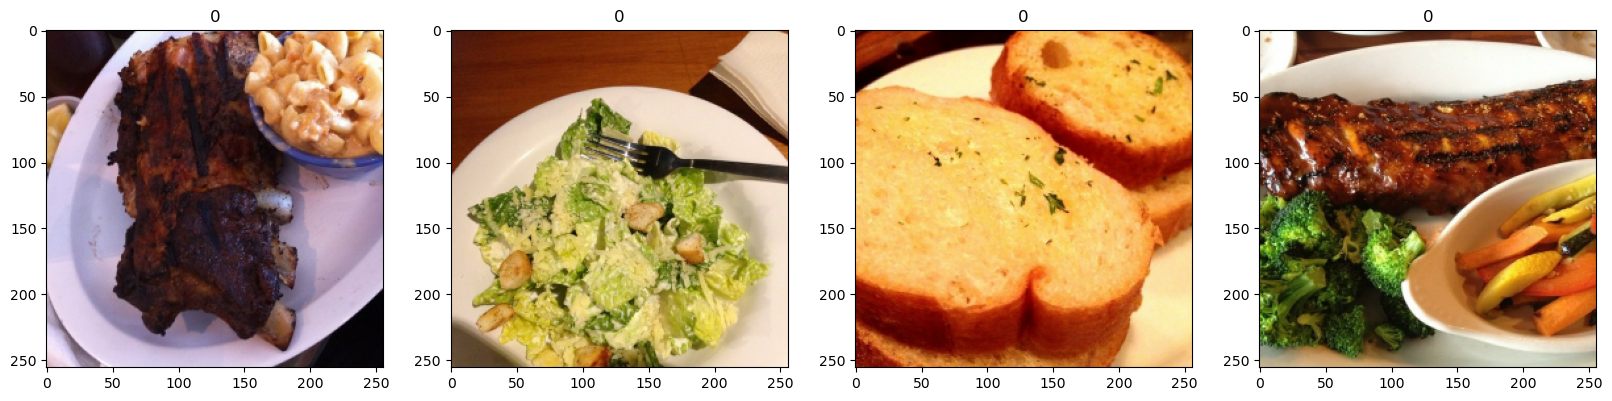

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.01960784, 0.        ],
          [0.        , 0.01960784, 0.        ],
          [0.        , 0.01960784, 0.        ],
          ...,
          [0.        , 0.01568628, 0.        ],
          [0.        , 0.01568628, 0.        ],
          [0.        , 0.01568628, 0.        ]],
 
         [[0.        , 0.01960784, 0.        ],
          [0.        , 0.01960784, 0.        ],
          [0.        , 0.01960784, 0.        ],
          ...,
          [0.        , 0.01568628, 0.        ],
          [0.        , 0.01568628, 0.        ],
          [0.        , 0.01568628, 0.        ]],
 
         [[0.        , 0.01960784, 0.        ],
          [0.        , 0.01960784, 0.        ],
          [0.        , 0.01960784, 0.        ],
          ...,
          [0.        , 0.01568628, 0.        ],
          [0.        , 0.01568628, 0.        ],
          [0.        , 0.01568628, 0.        ]],
 
         ...,
 
         [[0.10588235, 0.1254902 , 0.10196079],
          [0.11568

# 5. Split Data

In [18]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)
test_size = int(len(data)*.2)

In [19]:
train_size

251

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Model

In [21]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
251/251 [==============================] - 282s 1s/step - loss: 0.1953 - accuracy: 0.9234 - val_loss: 0.1965 - val_accuracy: 0.9292
Epoch 2/10
251/251 [==============================] - 310s 1s/step - loss: 0.1220 - accuracy: 0.9565 - val_loss: 0.1586 - val_accuracy: 0.9458
Epoch 3/10
251/251 [==============================] - 285s 1s/step - loss: 0.0837 - accuracy: 0.9701 - val_loss: 0.1994 - val_accuracy: 0.9465
Epoch 4/10
251/251 [==============================] - 216s 858ms/step - loss: 0.0561 - accuracy: 0.9811 - val_loss: 0.2499 - val_accuracy: 0.9447
Epoch 5/10
251/251 [==============================] - 216s 858ms/step - loss: 0.0369 - accuracy: 0.9875 - val_loss: 0.1868 - val_accuracy: 0.9507
Epoch 6/10
251/251 [==============================] - 288s 1s/step - loss: 0.0248 - accuracy: 0.9933 - val_loss: 0.2024 - val_accuracy: 0.9578
Epoch 7/10
251/251 [==============================] - 222s 884ms/step - loss: 0.0190 - accuracy: 0.9954 - val_loss: 0.2282 - val_accurac

# 8. Plot 

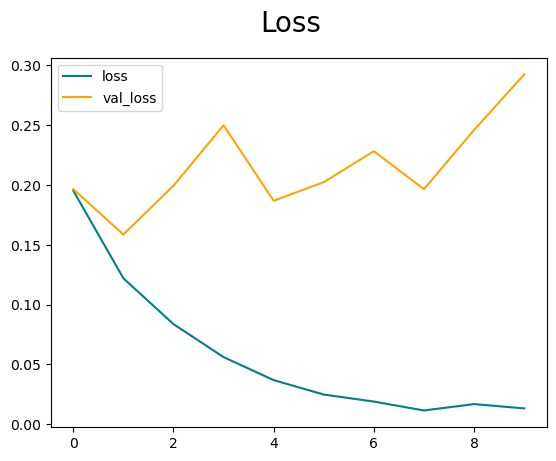

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

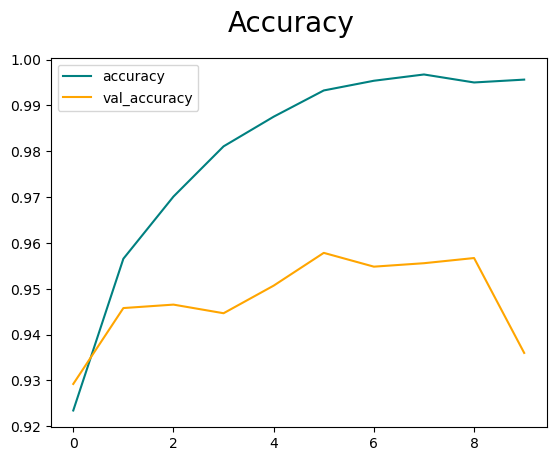

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluating the model

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 129ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.7191977, shape=(), dtype=float32) tf.Tensor(0.7795031, shape=(), dtype=float32) tf.Tensor(0.9363705, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

### Non bio-degradable waste:

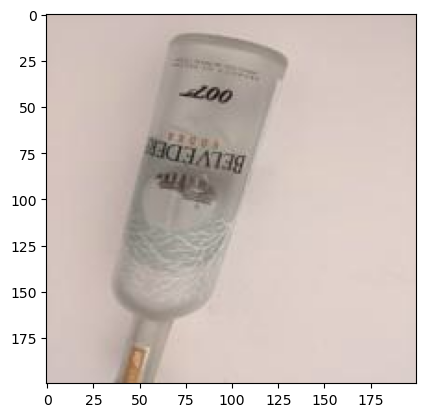

In [37]:
img = cv2.imread('non.jpg')
plt.imshow(img)
plt.show()

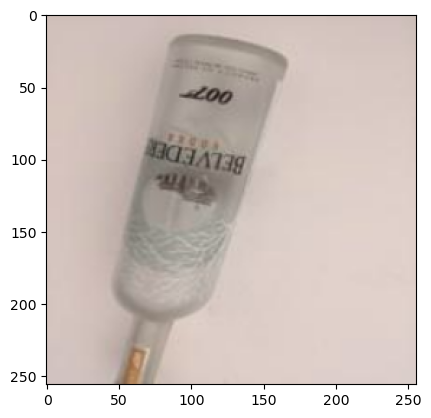

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 94ms/step


In [40]:
yhat

array([[0.9700142]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is Non-Biodegradable')
else:
    print(f'Predicted class is Biodegradable')

Predicted class is Non-Biodegradable


### Bio degradable waste:

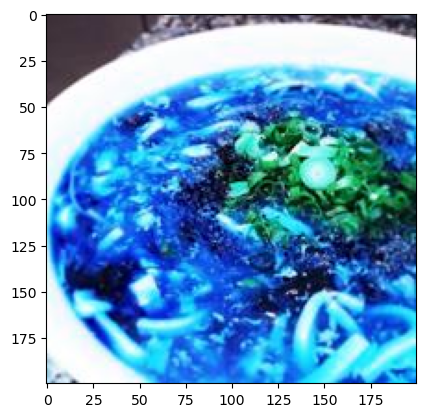

In [42]:
img = cv2.imread('bio.jpg')
plt.imshow(img)
plt.show()

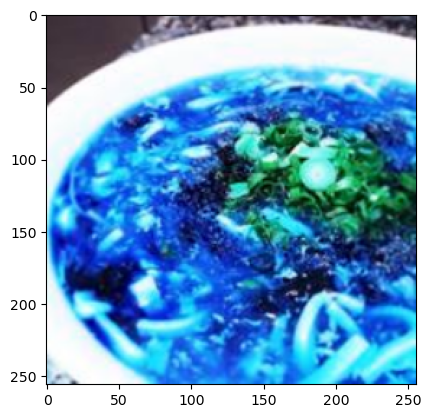

In [43]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 29ms/step


In [45]:
yhat

array([[0.25887147]], dtype=float32)

In [46]:
if yhat > 0.5: 
    print(f'Predicted class is Non-Biodegradable')
else:
    print(f'Predicted class is Biodegradable')

Predicted class is Biodegradable


# 11. Save the Model

In [53]:
from tensorflow.keras.models import load_model

In [54]:
model.save(os.path.join('models','final_model_2.h5'))